In [4]:
import torch
import torch.nn
import torchvision

from torch import nn
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import os
import time
import random
import io
print(f"torch version : {torch.__version__}")

torch version : 2.0.0


In [13]:
model_paths = ["C:/junha/Personal_Notebook/models/efficientNet_OverSampling.pth",
               "C:/junha/Personal_Notebook/models/efficientNetV2_OverSampling.pth",
               "C:/junha/Personal_Notebook/models/swinTransformer_OverSampling.pth",
               "C:/junha/Personal_Notebook/models/swinTransformer_Tiny_OverSampling.pth",
               "C:/junha/Personal_Notebook/models/tinyVGG_OverSampling.pth",
               ]

In [14]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN explainer
  """
  def __init__(self,
                input_shape:int,
                hidden_units:int,
                output_shape = int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 127890,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x=self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
      #return self.classifier(self.conv_block2(self.conv_block_1(x))) # benefits from opterator fusion

In [15]:
tinyVGG = TinyVGG(input_shape=3, hidden_units=10, output_shape=2)

In [16]:
model_names = ["EfficientNet B0", "EfficientNet V2 Large", "Swin Transformer Base", "Swin Transformer Tiny", "tinyVGG"]
models = [
    torchvision.models.efficientnet_b0(),
    torchvision.models.efficientnet_v2_l(),
    torchvision.models.swin_v2_b(),
    torchvision.models.swin_v2_t(),
    tinyVGG
]

In [17]:
image_folder = "C:\junha\Personal_Notebook\oversampling_data\z_keep_out_for_final_test"
classes = ['defect', 'normal']

In [18]:
image_size = (2532, 824) 

In [19]:
transform = transforms.Compose([
    transforms.Resize(image_size),  # Ensure size matches the model's input requirements
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
for i, model in enumerate(models):
    # Adjust classifier for 2 classes
    if 'efficientnet' in model.__class__.__name__.lower():
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
    elif 'swin' in model.__class__.__name__.lower():
        model.head = torch.nn.Linear(model.head.in_features, 2)
    
    # Load state dictionary
    state_dict = torch.load(model_paths[i])
    model.load_state_dict(state_dict)
    model.eval()
    print(f"Model #{i} loaded successfully.")


Model #0 loaded successfully.
Model #1 loaded successfully.
Model #2 loaded successfully.
Model #3 loaded successfully.
Model #4 loaded successfully.


In [21]:
all_images = []
for label, class_name in enumerate(classes):
    class_folder = os.path.join(image_folder, class_name)
    for filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, filename)
        all_images.append((image_path, label))  

# Shuffle images for random processing
random.shuffle(all_images)

In [22]:
# Initialize lists to store accuracy and timing for each model
accuracies = []
average_times = []

# Evaluate each model with tqdm
for model, model_name in zip(models, model_names):
    correct_predictions = 0
    total_images = 0
    processing_times = []

    # Progress bar for each model's evaluation
    with torch.no_grad():
        for image_path, label in tqdm(all_images, desc=f"Evaluating {model_name} on shuffled images"):
            image = Image.open(image_path).convert("RGB")
            image = transform(image).unsqueeze(0)

            # Measure inference time
            start_time = time.time()
            output = model(image)
            end_time = time.time()

            # Record time and calculate prediction
            processing_times.append(end_time - start_time)
            _, predicted = torch.max(output, 1)

            # Print actual and predicted labels
            actual_label = classes[label]
            predicted_label = classes[predicted.item()]
        

            # Update accuracy counters
            correct_predictions += (predicted.item() == label)
            total_images += 1

    # Calculate accuracy and average processing time for the model
    accuracy = correct_predictions / total_images
    avg_time = sum(processing_times) / len(processing_times)

    # Store results
    accuracies.append(accuracy)
    average_times.append(avg_time)

    # Print model-specific results
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Average Processing Time per Image: {avg_time:.4f} seconds\n")

# Final summary of accuracies and average times for all models
print("Summary of Model Performance:")
for model_name, accuracy, avg_time in zip(model_names, accuracies, average_times):
    print(f"Model: {model_name} | Accuracy: {accuracy:.4f} | Average Time: {avg_time:.4f} seconds")

Evaluating EfficientNet B0 on shuffled images: 100%|██████████| 40/40 [00:43<00:00,  1.10s/it]



Model: EfficientNet B0
Accuracy: 0.9500
Average Processing Time per Image: 1.0587 seconds


Evaluating EfficientNet V2 Large on shuffled images: 100%|██████████| 40/40 [04:00<00:00,  6.01s/it]



Model: EfficientNet V2 Large
Accuracy: 0.9500
Average Processing Time per Image: 5.9731 seconds


Evaluating Swin Transformer Base on shuffled images: 100%|██████████| 40/40 [04:09<00:00,  6.24s/it]



Model: Swin Transformer Base
Accuracy: 1.0000
Average Processing Time per Image: 6.2056 seconds


Evaluating Swin Transformer Tiny on shuffled images: 100%|██████████| 40/40 [01:41<00:00,  2.55s/it]



Model: Swin Transformer Tiny
Accuracy: 1.0000
Average Processing Time per Image: 2.5119 seconds


Evaluating tinyVGG on shuffled images: 100%|██████████| 40/40 [00:09<00:00,  4.20it/s]


Model: tinyVGG
Accuracy: 1.0000
Average Processing Time per Image: 0.2003 seconds

Summary of Model Performance:
Model: EfficientNet B0 | Accuracy: 0.9500 | Average Time: 1.0587 seconds
Model: EfficientNet V2 Large | Accuracy: 0.9500 | Average Time: 5.9731 seconds
Model: Swin Transformer Base | Accuracy: 1.0000 | Average Time: 6.2056 seconds
Model: Swin Transformer Tiny | Accuracy: 1.0000 | Average Time: 2.5119 seconds
Model: tinyVGG | Accuracy: 1.0000 | Average Time: 0.2003 seconds


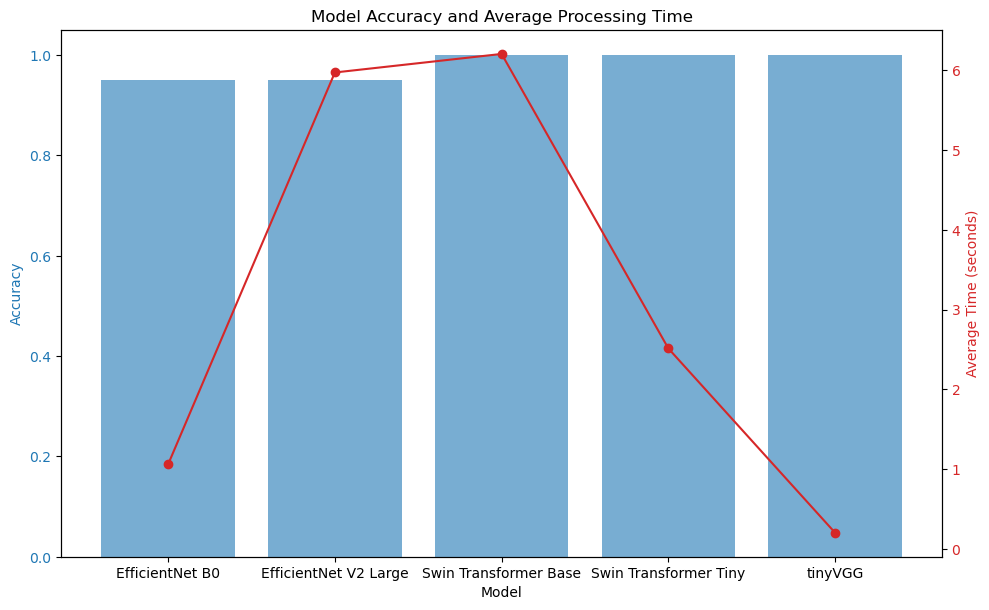

In [24]:
# Plot accuracy and processing time for each model
model_names = ["EfficientNet B0", "EfficientNet V2 Large", "Swin Transformer Base", "Swin Transformer Tiny", "tinyVGG"]
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy
ax1.set_xlabel("Model")
ax1.set_ylabel("Accuracy", color="tab:blue")
ax1.bar(model_names, accuracies, color="tab:blue", alpha=0.6, label="Accuracy")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Create a second y-axis for processing time
ax2 = ax1.twinx()
ax2.set_ylabel("Average Time (seconds)", color="tab:red")
ax2.plot(model_names, average_times, color="tab:red", marker="o", label="Processing Time")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Add legends
fig.tight_layout()
plt.title("Model Accuracy and Average Processing Time")
plt.show()